In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the libraries

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
mpl.rcParams['font.family'] = 'Droid Sans'
mpl.rcParams['font.size'] = 12
# Edit axes parameters
mpl.rcParams['axes.linewidth'] = 1.5
# Tick properties
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'

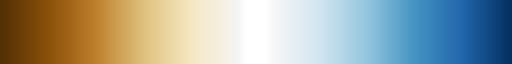

In [4]:
n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu
lower = cmap(np.linspace(0, diff, n))
white = np.ones((2, 4))
upper = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, white, upper))
BrBU = mpl.colors.LinearSegmentedColormap.from_list('map_white', colors)
BrBU

In [5]:
import os

In [6]:
model_list = sorted(os.listdir('/scratch/ob22/as8561/data/preproc/'))[1:]
# model_list2 = sorted(os.listdir('/scratch/ob22/as8561/data/preproc/'))[18:]
model_list#.extend(model_list2)

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'CESM2',
 'CESM2-WACCM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-1',
 'EC-Earth3',
 'EC-Earth3-Veg-LR',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL',
 'obs',
 'rean']

In [7]:
len(model_list)

32

In [9]:
import climtas
from scipy import stats
# import seaborn as sns
import pandas as pd
from dateutil.relativedelta import relativedelta
import regionmask

def find_indices(nino_events, nina_events):
    nino_idx = []
    nina_idx = []
    for i in range(len(nino_events)):
        start_en = nino_events['time'].to_numpy()[i]
        end_en = nino_events['event_duration'].to_numpy()[i]
        for j in range(end_en):
            nino_idx.append(start_en+j)
    for i in range(len(nina_events)):
        start_ln = nina_events['time'].to_numpy()[i]
        end_ln = nina_events['event_duration'].to_numpy()[i]
        for j in range(end_ln):
            nina_idx.append(start_ln+j)
    return nino_idx, nina_idx

###

def get_event_indices(nino_anom, threshold, min_duration, rolling_period):
    # import climtas
    nino_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') > threshold, min_duration=min_duration)
    nina_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') < -threshold, min_duration=min_duration)
    nino_idx, nina_idx = find_indices(nino_events, nina_events)
    enso_idx = np.sort(np.concatenate((nino_idx, nina_idx)))
    total = np.arange(0, len(nino_anom))
    neut_idx = np.delete(total, enso_idx)
    return nino_idx, nina_idx, neut_idx

###

# functions to calculate correlation value
def get_corr_1d(x, y):
    statistic, _ = stats.spearmanr(x, y)
    return statistic


def get_pval_1d(x, y):
    _, pval = stats.spearmanr(x, y)
    return pval


def get_corr(x, y, dim):
    return xr.apply_ufunc(get_corr_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')


def get_pval(x, y, dim):
    return xr.apply_ufunc(get_pval_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')

####

def calc_anom(
    input_da,
    base_start_date: str = "1960-01-01",
    base_end_date: str = "1990-01-01",
    start_year: str = "1891-01-01",
    end_year: str = "2015-01-01",
    # var = "Temperature",
    # units = 'K'
):

    # define the base climatology
    base_clim = input_da.sel(time=slice(base_start_date, base_end_date))

    # calculate the monthly climatology for the base years
#     da_clim_coarsen = base_clim.coarsen(time=12)
    da_clim = base_clim.groupby("time.month").mean("time")
    da_anom = input_da.sel(time = slice(start_year, end_year)).groupby("time.month") - da_clim
    
    return da_anom


####

def reorder(da):
    da['time'] = pd.date_range('1891-01-01', '2015-01-01', freq='1M')

    custom = da.sel(time=da.time.dt.month.isin([6,7,8,9,10,11,12,1,2,3,4,5]))
    # convert cftime to datetime
    datetimeindex = custom.indexes['time']#.to_datetimeindex() 
    # custom['time'] = pd.to_datetime(datetimeindex)
    
    # Add custom group by year functionality
    custom_year = custom['time'].dt.year
    
    # convert time type to pd.Timestamp
    time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    # time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    
    # Add year to Timestamp objects when month is before Jan. (relativedelta does not work from np.datetime64)
    time2 = [i + relativedelta(years=1) if i.month>=6 else i for i in time1] 
    custom['time'] = time2
    return custom

####


# def extract_results(detrended_var, nino_anom, base_var, season_str=None, threshold=0.8, min_duration=6, rolling_period=5):
#     weights = np.cos(np.deg2rad(detrended_var.lat))
#     weights.name = 'weights'
#     # reorder the vars
#     base_var = base_var.weighted(weights).mean(('lat', 'lon'))
#     detrended_var = reorder(detrended_var).weighted(weights).mean(('lat', 'lon'))
#     nino_anom = reorder(nino_anom)
#     if season_str=='ann': # for the annual period
#         # extract the indices
#         nino_idx, nina_idx, neut_idx = get_event_indices(nino_anom, threshold, min_duration, rolling_period)
#         # get the standard devitation of the detrended var
#         var_std = float(detrended_var.groupby('time.year').mean('time').std('year'))
#         # get the climatology of the base var
#         var_clim = float(base_var.mean('month'))
#         # get the overall teleconnection
#         var_corr = float(get_corr(nino_anom.groupby('time.year').mean('time'), detrended_var.groupby('time.year').mean('time'), 'year'))
#         var_pval = float(get_pval(nino_anom.groupby('time.year').mean('time'), detrended_var.groupby('time.year').mean('time'), 'year'))
#         # get the nino_event_months
#         neut = float((detrended_var[neut_idx].groupby('time.year').mean('time')).median('year'))
#         nino = float((detrended_var[nino_idx].groupby('time.year').mean('time')).median('year'))
#         nina = float((detrended_var[nina_idx].groupby('time.year').mean('time')).median('year'))
#         # calc nino_change
#         enc = (nino-neut)
#         lnc = (nina-neut)
#         # calc index
#         lin = (enc - lnc)/2
#         nonl = (enc + lnc)/2
#         # index ratio
#         ratio = nonl/np.abs(lin)
#         # get the contribs
#         if np.abs(enc) > np.abs(lnc):
#             lin_pc = lin/enc
#             nonl_pc = nonl/enc
#             nature = 1
#         elif np.abs(enc) < np.abs(lnc):
#             lin_pc = -lin/lnc
#             nonl_pc = nonl/lnc
#             nature = -1
#         else:
#             lin_pc = 0
#             nonl_pc = 0
#             nature = 0
#         return {
#             'std': var_std,
#             'clim': var_clim,
#             'corr': var_corr,
#             'pval': var_pval,
#             'neut': neut,
#             'nino': nino,
#             'nina': nina,
#             'enc': enc,
#             'lnc': lnc,
#             'nonl': nonl,#.where(np.abs(var_corr) >= 0.1, other=0),
#             'lin': lin,#.where(np.abs(var_corr) >= 0.1, other=0),
#             'ratio': ratio,#.where(np.abs(var_corr) >= 0.1, other=0),
#             'lin_pc': lin_pc,#.where(np.abs(var_corr) >= 0.1, other=0),
#             'nonl_pc': nonl_pc,#.where(np.abs(var_corr) >= 0.1, other=0),
#             'nature': nature,#.where(np.abs(var_corr) >= 0.1, other=np.nan),
#         }
#     else:
#         seasons_dict = {'djf':[12,1,2], 'mam':[3,4,5], 'jja':[6,7,8], 'son':[9,10,11]}
#         # extract the indices
#         nino_idx, nina_idx, neut_idx = get_event_indices(nino_anom, threshold, min_duration, rolling_period)
#         # define the season arr
#         season_month_arr = seasons_dict[season_str]
#         # get the season for the individual cases
#         season = detrended_var.time.dt.month.isin(season_month_arr)
#         nino_season = detrended_var[nino_idx].time.dt.month.isin(season_month_arr)
#         nina_season = detrended_var[nina_idx].time.dt.month.isin(season_month_arr)
#         neut_season = detrended_var[neut_idx].time.dt.month.isin(season_month_arr)
#         # get the std of detrended var for that season
#         var_std = float(detrended_var.sel(time=season).groupby('time.year').mean('time').std('year'))
#         # get the climatology of the base var
#         var_clim = float(base_var.sel(month = season_month_arr).mean('month'))
#         # get the overall teleconnection
#         var_corr = float(get_corr(nino_anom.sel(time=season).groupby('time.year').mean('time'), detrended_var.sel(time=season).groupby('time.year').mean('time'), 'year'))
#         var_pval = float(get_pval(nino_anom.sel(time=season).groupby('time.year').mean('time'), detrended_var.sel(time=season).groupby('time.year').mean('time'), 'year'))
#         # get the nino_event_months
#         neut = float((detrended_var[neut_idx].sel(time=neut_season).groupby('time.year').mean('time')).median('year'))
#         nino = float((detrended_var[nino_idx].sel(time=nino_season).groupby('time.year').mean('time')).median('year'))
#         nina = float((detrended_var[nina_idx].sel(time=nina_season).groupby('time.year').mean('time')).median('year'))
#         # calc nino_change
#         enc = (nino-neut)
#         lnc = (nina-neut)
#         # calc index
#         nonl = (enc + lnc)/2
#         lin = (enc - lnc)/2
#         # index ratio
#         ratio = nonl/np.abs(lin)
#         # get the contribs
#         if np.abs(enc) > np.abs(lnc):
#             lin_pc = lin/enc
#             nonl_pc = nonl/enc
#             nature = 1
#         elif np.abs(enc) < np.abs(lnc):
#             lin_pc = -lin/lnc
#             nonl_pc = nonl/lnc
#             nature = -1
#         else:
#             lin_pc = 0
#             nonl_pc = 0
#             nature = 0
#         return {
#             'std': var_std,
#             'clim': var_clim,
#             'corr': var_corr,
#             'pval': var_pval,
#             'neut': neut,
#             'nino': nino,
#             'nina': nina,
#             'enc': enc,
#             'lnc': lnc,
#             'nonl': nonl,#.where(np.abs(var_corr) >= 0.1, other=0),
#             'lin': lin,#.where(np.abs(var_corr) >= 0.1, other=0),
#             'ratio': ratio,#.where(np.abs(var_corr) >= 0.1, other=0),
#             'lin_pc': lin_pc,#.where(np.abs(var_corr) >= 0.1, other=0),
#             'nonl_pc': nonl_pc,#.where(np.abs(var_corr) >= 0.1, other=0),
#             'nature': nature,#.where(np.abs(var_corr) >= 0.1, other=np.nan),
#         }

In [10]:
# def calc_data_res(model_list):
#     base_loc = '/scratch/ob22/as8561/data/'
#     std_arr = np.empty((5, 46, 32))
#     clim_arr = np.empty((5, 46, 32))
#     corr_arr = np.empty((5, 46, 32))
#     pval_arr = np.empty((5, 46, 32))
#     neut_arr = np.empty((5, 46, 32))
#     nino_arr = np.empty((5, 46, 32))
#     nina_arr = np.empty((5, 46, 32))
#     enc_arr = np.empty((5, 46, 32))
#     lnc_arr = np.empty((5, 46, 32))
#     nonl_arr = np.empty((5, 46, 32))
#     lin_arr = np.empty((5, 46, 32))
#     ratio_arr = np.empty((5, 46, 32))
#     linpc_arr = np.empty((5, 46, 32))
#     nonlpc_arr = np.empty((5, 46, 32))
#     nature_arr = np.empty((5, 46, 32))
#     threshold_arr = []
#     ## start the model for loop
#     for model_idx in range(len(model_list)):
#         # get all the data
#         precip = xr.open_dataset(base_loc + f'preproc/{model_list[model_idx]}/precip.nc').load().precip
#         precip = precip.assign_coords({"lon": (((precip.lon + 180) % 360) - 178.5)})
#         precip = precip.sortby(precip.lon)
#         nino = xr.open_dataset(base_loc + f'preproc/{model_list[model_idx]}/nino.nc').load().nino
#         if model_list[model_idx]=='obs':
#             precip_base = xr.open_dataset(base_loc + f'preproc/{model[model_idx]}/base_precip.nc').load().precip
#             precip_base = precip_base.assign_coords({"lon": (((precip_base.lon + 180) % 360) - 178.5)})
#             precip_base = precip_base.sortby(precip_base.lon)
#         elif model_list[model_idx]=='rean':
#             precip_base = xr.open_dataset(base_loc + f'preproc/{model_list[model_idx]}/base_precip.nc').load().prate
#             precip_base = precip_base.assign_coords({"lon": (((precip_base.lon + 180) % 360) - 178.5)})
#             precip_base = precip_base.sortby(precip_base.lon)
#         else: 
#             precip_base = xr.open_dataset(base_loc + f'preproc/{model_list[model_idx]}/base_precip.nc').load().pr
#             precip_base = precip_base.assign_coords({"lon": (((precip_base.lon + 180) % 360) - 178.5)})
#             precip_base = precip_base.sortby(precip_base.lon)
#         # get nino threshold
#         threshold = float(nino.std())
#         threshold_arr.append(threshold)
#         ## start the region loop
#         # mask the land area firt
#         land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask_3D(precip, wrap_lon=False, drop=False)
#         precip_land = precip.where(land_mask.isel(region=0))
#         precip_base_land = precip_base.where(land_mask.isel(region=0))
#         # mask for the ar6 land regions
#         ar6_mask = regionmask.defined_regions.ar6.land.mask_3D(precip_land, wrap_lon=False, drop=False)
#         ar6_list = regionmask.defined_regions.ar6.land.to_dataframe()['names'].to_numpy()
#         for ar6_idx in range(len(ar6_list)):
#             season_list = ['ann', 'djf', 'mam', 'jja', 'son']
#             for season_idx in range(len(season_list)):
#                 res = extract_results(precip_land.where(ar6_mask.isel(region=ar6_idx)), nino, precip_base_land.where(ar6_mask.isel(region=ar6_idx)), \
#                                          season_str=season_list[season_idx], threshold=threshold, min_duration=6, rolling_period=5)
#                 std_arr[season_idx, ar6_idx, model_idx] = res['std']
#                 clim_arr[season_idx, ar6_idx, model_idx] = res['clim']
#                 corr_arr[season_idx, ar6_idx, model_idx] = res['corr']
#                 pval_arr[season_idx, ar6_idx, model_idx] = res['pval']
#                 neut_arr[season_idx, ar6_idx, model_idx] = res['neut']
#                 nino_arr[season_idx, ar6_idx, model_idx] = res['nino']
#                 nina_arr[season_idx, ar6_idx, model_idx] = res['nina']
#                 enc_arr[season_idx, ar6_idx, model_idx] = res['enc']
#                 lnc_arr[season_idx, ar6_idx, model_idx] = res['lnc']
#                 nonl_arr[season_idx, ar6_idx, model_idx] = res['nonl']
#                 lin_arr[season_idx, ar6_idx, model_idx] = res['lin']
#                 ratio_arr[season_idx, ar6_idx, model_idx] = res['ratio']
#                 linpc_arr[season_idx, ar6_idx, model_idx] = res['lin_pc']
#                 nonlpc_arr[season_idx, ar6_idx, model_idx] = res['nonl_pc']
#                 nature_arr[season_idx, ar6_idx, model_idx] = res['nature']
#             print(f'Completed Region : {ar6_idx + 1}/{len(ar6_list)} -> {ar6_list[ar6_idx]}', end='\r')
#         print(f'Completed Model : {model_idx + 1}/{len(model_list)} -> {model_list[model_idx]}', end='\r')
#     ds = xr.Dataset(
#         data_vars=dict(
#             std = (["season", "region", "model"], std_arr),
#             clim = (["season", "region", "model"], clim_arr),
#             corr = (["season", "region", "model"], corr_arr),
#             pval = (["season", "region", "model"], pval_arr),
#             neut = (["season", "region", "model"], neut_arr),
#             nino = (["season", "region", "model"], nino_arr),
#             nina = (["season", "region", "model"], nina_arr),
#             enc = (["season", "region", "model"], enc_arr),
#             lnc = (["season", "region", "model"], lnc_arr),
#             nonl = (["season", "region", "model"], nonl_arr),
#             lin = (["season", "region", "model"], lin_arr),
#             ratio = (["season", "region", "model"], ratio_arr),
#             lin_pc = (["season", "region", "model"], linpc_arr),
#             nonl_pc = (["season", "region", "model"], nonlpc_arr),
#             nature = (["season", "region", "model"], nature_arr),
#             threshold = (["model"], threshold_arr),
#         ),
#         coords = dict(
#             season = (["season"], season_list),
#             region = (["region"], ar6_list),
#             model = (["model"], model_list),
#         ),
#         attrs = dict(
#             description="Results for all seasons, regions, models as well as obs and rean"
#         )
#     )
#     print('Complete')
#     return ds

In [11]:
# ds = calc_data_res(model_list=model_list)

In [12]:
# ds.to_netcdf('./')

In [23]:
# Function to preprocess the regridded data


import xarray as xr
from statsmodels.tsa.seasonal import STL
import pymannkendall as mk

def detrend1d(arr, period = 9*12):
    trend = mk.hamed_rao_modification_test(arr).trend
    if trend != 'no trend':
        res = STL(arr, period = period).fit()
        arr_det = arr - res.trend
        return arr_det
    else:
        return arr

# def detrend_separate(da, period=9):
#     trend = da.rolling(time = period*12).mean('time')
#     da_detrend = da - trend
#     return da_detrend
def detrend_separate(da, dim):
    return xr.apply_ufunc(detrend1d, da, input_core_dims=[[dim]], output_core_dims=[[dim]])

In [14]:
xr.open_dataset('/scratch/ob22/as8561/data/preproc/obs/nino.nc').nino

<xarray.DataArray 'nino' (time: 1488)>
[1488 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1891-01-16T12:00:00 ... 2014-12-16T12:00:00
    month    (time) int64 ...

In [25]:
def extract_results_parallel(var, nino34, base_var, season_str=None, threshold=0.8):
    weights = np.cos(np.deg2rad(var.lat))
    weights.name = 'weights'
    # reorder the vars
    var = var.weighted(weights).mean(('lat', 'lon'))
    var_std = var.groupby('time.season').std('time')
    var_anom = calc_anom(var)
    if season_str=='ann': # for the annual period
        detrended_var = detrend_separate(reorder(var_anom), 'time')
        nino34 = reorder(nino34)
        # extract the indices
        # get the standard devitation of the detrended var
        var_std = float(detrended_var.groupby('time.year').mean('time').std('year'))
        # get the climatology of the base var
        var_clim = float(base_var.mean('month'))
        # get the overall teleconnection
        var_corr = float(get_corr(nino_anom_det.groupby('time.year').mean('time'), detrended_var.groupby('time.year').mean('time'), 'year'))
        var_pval = float(get_pval(nino_anom_det.groupby('time.year').mean('time'), detrended_var.groupby('time.year').mean('time'), 'year'))
        # get the nino_event_months
        neut = float((detrended_var[np.where((nino_anom_det.rolling(time=3).mean('time') < threshold) & (nino_anom_det.rolling(time=3).mean('time') > -threshold))].groupby('time.year').mean('time')).median('year'))
        nino = float((detrended_var[nino_anom_det.rolling(time=3).mean('time') > threshold].groupby('time.year').mean('time')).median('year'))
        nina = float((detrended_var[nino_anom_det.rolling(time=3).mean('time') < \
                      -threshold].groupby('time.year').mean('time')).median('year'))
        # calc nino_change
        enc = (nino-neut)
        lnc = (nina-neut)
        # calc index
        lin = (enc - lnc)/2
        nonl = (enc + lnc)/2
        # index ratio
        ratio = nonl/np.abs(lin)
        # get the contribs
        if np.abs(enc) > np.abs(lnc):
            lin_pc = lin/enc
            nonl_pc = nonl/enc
            nature = 1
        elif np.abs(enc) < np.abs(lnc):
            lin_pc = -lin/lnc
            nonl_pc = nonl/lnc
            nature = -1
        else:
            lin_pc = 0
            nonl_pc = 0
            nature = 0
        return var_std, var_clim, var_corr, var_pval, neut, nino, nina, enc, lnc, nonl, lin, ratio, lin_pc, nonl_pc, nature
    else:
        # seasons_dict = {'djf':[12,1,2], 'mam':[3,4,5], 'jja':[6,7,8], 'son':[9,10,11]}
        # extract the indices
        # define the season arr
        season_month_arr = season_str#seasons_dict[season_str]
        # get the season for the individual cases
        season = var.time.dt.month.isin(season_month_arr)
        detrended_var = detrend_separate(var.sel(time = season), 'time')
        # get the std of detrended var for that season
        var_std = float(detrended_var.groupby('time.year').mean('time').std('year'))
        # get the climatology of the base var
        var_clim = float(base_var.sel(month = season_month_arr).mean('month'))
        # get the overall teleconnection
        var_corr = float(get_corr(nino_anom_det.sel(time=season).groupby('time.year').mean('time'), detrended_var.groupby('time.year').mean('time'), 'year'))
        var_pval = float(get_pval(nino_anom_det.sel(time=season).groupby('time.year').mean('time'), detrended_var.groupby('time.year').mean('time'), 'year'))
        # get the nino_event_months
        neut = float((detrended_var[np.where((nino_anom_det.rolling(time=3).mean('time').sel(time = season) < threshold) & (nino_anom_det.rolling(time=3).mean('time').sel(time = season) > -threshold))].groupby('time.year').mean('time')).median('year'))
        nino = float((detrended_var[nino_anom_det.rolling(time=3).mean('time').sel(time = season) > threshold].groupby('time.year').mean('time')).median('year'))
        nina = float((detrended_var[nino_anom_det.rolling(time=3).mean('time').sel(time = season) < \
                      -threshold].groupby('time.year').mean('time')).median('year'))
        # calc nino_change
        enc = (nino-neut)
        lnc = (nina-neut)
        # calc index
        nonl = (enc + lnc)/2
        lin = (enc - lnc)/2
        # index ratio
        ratio = nonl/np.abs(lin)
        # get the contribs
        if np.abs(enc) > np.abs(lnc):
            lin_pc = lin/enc
            nonl_pc = nonl/enc
            nature = 1
        elif np.abs(enc) < np.abs(lnc):
            lin_pc = -lin/lnc
            nonl_pc = nonl/lnc
            nature = -1
        else:
            lin_pc = 0
            nonl_pc = 0
            nature = 0
        return var_std, var_clim, var_corr, var_pval, neut, nino, nina, enc, lnc, nonl, lin, ratio, lin_pc, nonl_pc, nature


def calc_data_res_parallel(params):
    base_loc = '/scratch/ob22/as8561/data/preproc/'
    model = params[0]
    region = params[1]
    season = params[2]
    precip = xr.open_dataset(base_loc + f'{model}/precip.nc').precip#.load()
    precip = precip.assign_coords({"lon": (((precip.lon + 180) % 360) - 178.5)})
    precip_anom = precip.sortby(precip.lon)
    #
    nino34 = xr.open_dataset(base_loc + f'{model}/nino.nc').nino#.load()
    # get nino threshold
    threshold = nino34.std()
    ## start the region loop
    # mask the land area firt
    land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask_3D(precip_anom, wrap_lon=False, drop=False)
    precip_land = precip_anom.where(land_mask.isel(region=0))
    # mask for the ar6 land regions
    ar6_mask = regionmask.defined_regions.ar6.land.mask_3D(precip_land, wrap_lon=False, drop=False)
    # ar6_list = regionmask.defined_regions.ar6.land.to_dataframe()['names'].to_numpy()
    var_std, var_clim, var_corr, var_pval, neut, nino, nina, enc, lnc, nonl, lin, ratio, lin_pc, nonl_pc, nature = extract_results_parallel(precip_land.where(ar6_mask.isel(region=region)), nino34, season_str=season, threshold=threshold)
    return var_std, var_clim, var_corr, var_pval, neut, nino, nina, enc, lnc, nonl, lin, ratio, lin_pc, nonl_pc, nature
    # ds = xr.Dataset(
    #     data_vars=dict(
    #         std = (["season", "region", "model"], std_arr),
    #         clim = (["season", "region", "model"], clim_arr),
    #         corr = (["season", "region", "model"], corr_arr),
    #         pval = (["season", "region", "model"], pval_arr),
    #         neut = (["season", "region", "model"], neut_arr),
    #         nino = (["season", "region", "model"], nino_arr),
    #         nina = (["season", "region", "model"], nina_arr),
    #         enc = (["season", "region", "model"], enc_arr),
    #         lnc = (["season", "region", "model"], lnc_arr),
    #         nonl = (["season", "region", "model"], nonl_arr),
    #         lin = (["season", "region", "model"], lin_arr),
    #         ratio = (["season", "region", "model"], ratio_arr),
    #         lin_pc = (["season", "region", "model"], linpc_arr),
    #         nonl_pc = (["season", "region", "model"], nonlpc_arr),
    #         nature = (["season", "region", "model"], nature_arr),
    #         threshold = (["model"], threshold_arr),
    #     ),
    #     coords = dict(
    #         season = (["season"], season_list),
    #         region = (["region"], ar6_list),
    #         model = (["model"], model_list),
    #     ),
    #     attrs = dict(
    #         description="Results for all seasons, regions, models as well as obs and rean"
    #     )
    # )
    # print('Complete')
    # return ds

In [26]:
from multiprocessing import Pool
import itertools

In [27]:
region_list = regionmask.defined_regions.ar6.land.to_dataframe().index.to_numpy()
season_list = ['ann', [12,1,2], [3,4,5], [6,7,8], [9, 10, 11]]

In [28]:
param_arr = [model_list, region_list, season_list]

In [29]:
param_list = list(itertools.product(*param_arr))

In [52]:
name_list = ['std_dev', 'clim', 'corr_coef', 'pval', 'neut', 'nino', 'nina', 'enc', 'lnc', 'asymm', 'symm', 'ratio', 'symm_contrib', 'asymm_contrib', 'nature']

In [53]:
len(name_list)

15

In [54]:
def convert_to_da(arr, name):
    return xr.DataArray(
        data = arr,
        dims = ["season", "region", "model"],
        coords = dict(
            season = (["season"], ['ann', 'djf', 'mam', 'jja', 'son']),
            region = (["region"], region_list),
            model = (["model"], model_list),
        ),
        name = name
    )

In [33]:
res_arr = []
with Pool() as pool:
    i = 0
    for res in pool.imap(calc_data_res_parallel, param_list):
        res_arr.append(res)
        print(f'completed {i+1}/{5*46*32}', end='\r')
        i += 1

In [34]:
np.shape(res_arr)

(7360, 15)

In [55]:
res_arr = np.array(res_arr)
da_arr = []
for i in range(len(res_arr[0])):
    arr = np.reshape(res_arr[:, i], (5, 46, 32), order='F')
    da = convert_to_da(arr, name_list[i])
    da_arr.append(da)

In [56]:
ds=xr.merge(da_arr)

In [57]:
list(ds.keys())

['std_dev',
 'clim',
 'corr_coef',
 'pval',
 'neut',
 'nino',
 'nina',
 'enc',
 'lnc',
 'asymm',
 'symm',
 'ratio',
 'symm_contrib',
 'asymm_contrib',
 'nature']

In [59]:
ds.to_netcdf('./PhD/enso_precip_asymmetry/data/result/regional_res_new.nc')

In [9]:
out = xr.open_dataset('./PhD/enso_precip_asymmetry/data/result/regional_res_new.nc')
out

<xarray.Dataset>
Dimensions:        (season: 5, region: 46, model: 32)
Coordinates:
  * season         (season) object 'ann' 'djf' 'mam' 'jja' 'son'
  * region         (region) int64 0 1 2 3 4 5 6 7 8 ... 38 39 40 41 42 43 44 45
  * model          (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'obs' 'rean'
Data variables: (12/15)
    std_dev        (season, region, model) float64 ...
    clim           (season, region, model) float64 ...
    corr_coef      (season, region, model) float64 ...
    pval           (season, region, model) float64 ...
    neut           (season, region, model) float64 ...
    nino           (season, region, model) float64 ...
    ...             ...
    asymm          (season, region, model) float64 ...
    symm           (season, region, model) float64 ...
    ratio          (season, region, model) float64 ...
    symm_contrib   (season, region, model) float64 ...
    asymm_contrib  (season, region, model) float64 ...
    nature         (season, region, model) float64 ...

In [61]:
# plotting code
import matplotlib as m
from matplotlib.colors import BoundaryNorm as BM


def plot_background(ax):
    ax.add_feature(cfeature.COASTLINE, alpha=0.9, lw=0.9)
    ax.set_global()
    # ax.add_feature(cfeature.LAND, color='lightgray')
    # ax.add_feature(cfeature.OCEAN, color='lightgray')
    gl = ax.gridlines(draw_labels=True,
                      linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    # gl.left_labels = False
    # gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False
    # gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    return ax

def plot(x, y, z, titles, cmap, levels, cbar_label = 'Precip', pval = [], nrows=1, ncols=3, figsize=(12,4), ocean_mask_list = [0]):
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True, subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
    
    axlist = axarr.flatten()
    
    for ax in axlist:
        plot_background(ax)
    
    for i in range(len(z)):
        axlist[i].contourf(x, y, z[i], cmap = cmap, transform = ccrs.PlateCarree(central_longitude=180), levels=levels, extend='both')
        axlist[i].set_title(titles[i])
        if i in ocean_mask_list:
            axlist[i].add_feature(cfeature.OCEAN, color = 'lightgray', zorder=2)
        if pval != []:
            axlist[i].scatter(x[np.abs(pval) < 0.05], y[np.abs(pval) < 0.05], color = 'k', s = 0.1, marker='o', alpha = 0.8, transform = ccrs.PlateCarree(central_longitude=0))
        # axlist[i].set_title('IMD', fontdict={'fontsize':12})
        
    norm = BM(levels, 256, extend='both')
    fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap=cmap), ax = axlist, \
                orientation = 'horizontal', shrink=0.4, aspect = 20, pad = 0.05, label = cbar_label)

In [62]:
import seaborn as sns

In [63]:
region_names = regionmask.defined_regions.ar6.land.to_dataframe()['names'].to_numpy()
region_names

array(['Greenland/Iceland', 'N.W.North-America', 'N.E.North-America',
       'W.North-America', 'C.North-America', 'E.North-America',
       'N.Central-America', 'S.Central-America', 'Caribbean',
       'N.W.South-America', 'N.South-America', 'N.E.South-America',
       'South-American-Monsoon', 'S.W.South-America', 'S.E.South-America',
       'S.South-America', 'N.Europe', 'West&Central-Europe', 'E.Europe',
       'Mediterranean', 'Sahara', 'Western-Africa', 'Central-Africa',
       'N.Eastern-Africa', 'S.Eastern-Africa', 'W.Southern-Africa',
       'E.Southern-Africa', 'Madagascar', 'Russian-Arctic', 'W.Siberia',
       'E.Siberia', 'Russian-Far-East', 'W.C.Asia', 'E.C.Asia',
       'Tibetan-Plateau', 'E.Asia', 'Arabian-Peninsula', 'S.Asia',
       'S.E.Asia', 'N.Australia', 'C.Australia', 'E.Australia',
       'S.Australia', 'New-Zealand', 'E.Antarctica', 'W.Antarctica'],
      dtype=object)

In [64]:
ds

<xarray.Dataset>
Dimensions:        (season: 5, region: 46, model: 32)
Coordinates:
  * season         (season) <U3 'ann' 'djf' 'mam' 'jja' 'son'
  * region         (region) int64 0 1 2 3 4 5 6 7 8 ... 38 39 40 41 42 43 44 45
  * model          (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'obs' 'rean'
Data variables: (12/15)
    std_dev        (season, region, model) float64 2.864 2.429 ... nan 5.25
    clim           (season, region, model) float64 29.28 31.17 ... nan 45.99
    corr_coef      (season, region, model) float64 0.1849 0.01416 ... 0.09456
    pval           (season, region, model) float64 0.039 0.8755 ... nan 0.2962
    neut           (season, region, model) float64 0.07403 0.02338 ... -0.3958
    nino           (season, region, model) float64 1.273 -0.3802 ... nan -0.5405
    ...             ...
    asymm          (season, region, model) float64 -0.003095 0.09586 ... 0.2227
    symm           (season, region, model) float64 1.202 -0.4994 ... nan -0.3674
    ratio          (season, region, model) float64 -0.002575 0.1919 ... 0.6062
    symm_contrib   (season, region, model) float64 0.9974 0.839 ... 0.0 0.6226
    asymm_contrib  (season, region, model) float64 0.002568 0.161 ... 0.0 0.3774
    nature         (season, region, model) float64 -1.0 -1.0 -1.0 ... 0.0 -1.0

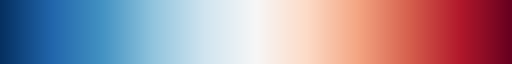

In [65]:
corr = out.isel(season = 0, model = -2)['corr_coef'].to_numpy()
pval = out.isel(season = 0, model = -2)['pval'].to_numpy()

min_val, max_val = min(corr), max(corr)

# use the coolwarm colormap that is built-in, and goes from blue to red
cmap = mpl.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=-0.7, vmax=0.7)
colors = cmap(plt.Normalize(min_val, max_val)(corr))
cmap

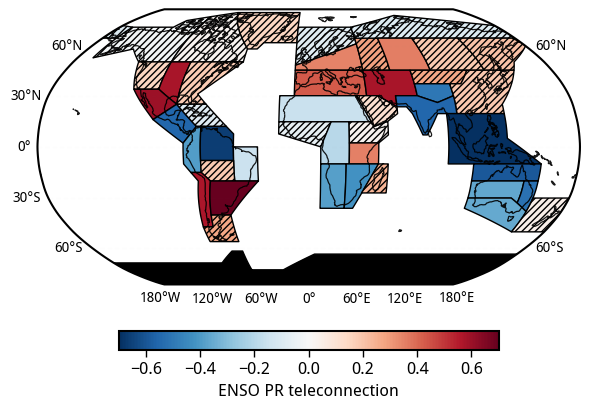

In [66]:
fig = plt.figure(figsize=(7,6))
ax = plt.axes(projection = ccrs.Robinson())
pg = regionmask.defined_regions.ar6.land.polygons
for i in range(len(pg)):
    if pval[i] > 0.05:
        ax.add_geometries(pg[i], crs=ccrs.PlateCarree(), facecolor=list(colors)[i], edgecolor='k', alpha=1.0, hatch='/////')
    else:
        ax.add_geometries(pg[i], crs=ccrs.PlateCarree(), facecolor=list(colors)[i], edgecolor='k', alpha=1.0, hatch='')
# fig.colorbar(cf, cmap=cmap, norm=norm, ticks = sorted(vals), orientation='horizontal')
# cb.set_label('vals')
# ax.tick_params(axis='x', rotation=90)
plot_background(ax)
plt.colorbar(m.cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, \
            orientation = 'horizontal', shrink=0.7, aspect = 20, pad = 0.10, label = 'ENSO PR teleconnection')

In [384]:
pval[:-2].max()

0.9386911923046903

In [378]:
region_names[38]

'S.E.Asia'

<GeoAxesSubplot:>

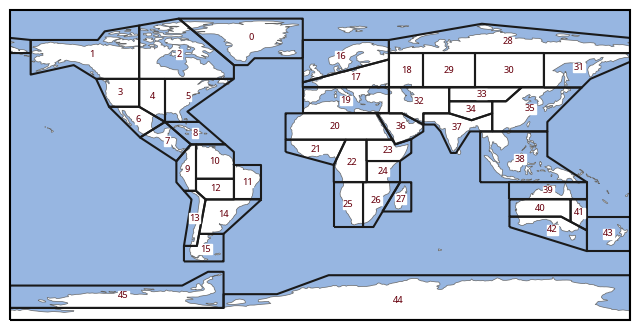

In [263]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection = ccrs.PlateCarree())
text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))
regionmask.defined_regions.ar6.land.plot(text_kws=text_kws, add_ocean=True)

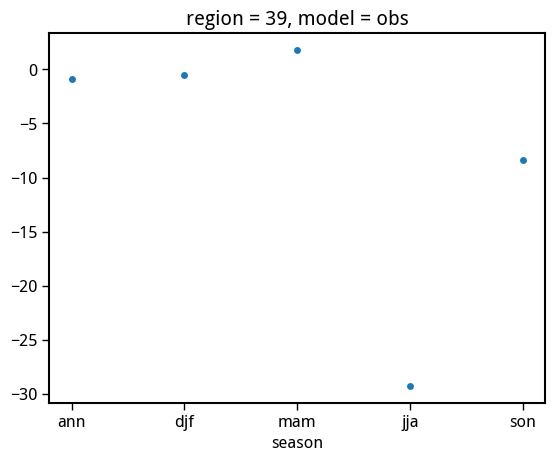

In [11]:
((out.isel(region=39, model = -2).neut/out.isel(region=39, model=-2).clim)*100).plot.scatter()

In [13]:
((out.isel(region=39, model = -2).neut/out.isel(region=39, model=-2).clim)*100).values

array([ -0.89288844,  -0.49335113,   1.81228061, -29.27501815,
        -8.4236115 ])

In [14]:
out.isel(region=39, model=-2).clim.values

array([ 77.97527903, 199.79697703,  77.92327175,   4.46832081,
        29.71254652])

In [15]:
out.isel(region=39, model=-2).neut.values

array([-0.69623225, -0.98570065,  1.41218835, -1.30810173, -2.50286949])

In [85]:
out.isel(region=41, model=-2).nina.values

array([11.05083998,  9.1813509 , -4.11473708,  5.96290962, 17.91065557])

In [86]:
out.isel(region=41, model=-2).nino.values

array([ -9.59074063, -16.51005322,   1.22657127, -15.03863389,
       -11.55074107])

In [78]:
out.isel(region=39, model=-2).corr_coef.values

array([-0.59176037, -0.12006924, -0.33559087, -0.19431629, -0.63607868])

In [79]:
out.isel(region=39, model=-2).pval.values

array([3.66852618e-13, 1.84077620e-01, 1.38830616e-04, 3.05752327e-02,
       2.05522924e-15])